# Visualizations of Stack Overflow Survey Data

By Michael A. Madaio, for the United Nations University, Institute on Computing and Society
<br> August, 2018

## Overview

Online developer communities boast millions of users - over 29 million on GitHub and over 8 million on Stack Overflow, in 2018. Participation in these communities is becoming one of the primary ways software developers learn new programming languages, improve their skills, develop collaborative projects, and find new job opportunities. [[1]](David and Shapiro, 2008) [[2]](Ford et al., 2016) [[3]](Vasilescu et al., 2015)  

Developers on these sites may ask and answer coding questions to improve their skills (e.g. Stack Overflow), use those skills to contribute to open-source code (e.g. GitHub) and participate in coding challenges (e.g. HackerRank). These platforms are becoming increasingly important to hiring decisions, as recruiters look at GitHub contributions or reputation on Stack Overflow as indicators of developers' skill.

However, despite the promise for these online developer communities to support software developers in their professional development, there are indicators that there may be serious difference in women and men's participation in these communities - differences which may further exacerbate existing gender gaps in the ICT workforce writ large.

## Research questions

To understand the extent and nature of the gender gap in online software developer communities, we ask the following research questions:

1. How do male and female developers differ in their participation in online software developer communities?
2. How do male and female developers differ in their perceptions of belonging and welcomingness in online software developer communities?
3. How do male and female developers in online software developer communities differ in their employment and prior experience with coding?

## Usage

In this notebook, we only use data from the Stack Overflow community survey. 
- Stack Overflow [survey](https://insights.stackoverflow.com/survey/2018/) (download latest survey results [here](https://drive.google.com/uc?export=download&id=1_9On2-nsBQIw3JiY43sWbrF8EjrqrR4U)).  

We generate cross-tabulation heatmaps and generate country-level maps of response percentages.

#### 1. Setup
#### 2. Age and Years of Coding Experience
#### 3. Education
#### 4. Employment
#### 5. Company Size
#### 6. CS Degrees
#### 7. Job Level

## 1. Setup

These lines hide the code blocks with a toggle button to display them.

These lines import the necessary package dependencies.

In [2]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import pandas.tools.plotting
import seaborn as sns
import matplotlib
%matplotlib inline

# Install "fuzzywuzzy" and "python-Levenshtein" using pip install
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

plt.style.use('seaborn')


import plotly.offline as offline
offline.init_notebook_mode(True)
import plotly.graph_objs as go
#plt.style.use('ggplot')
pd.options.display.max_rows =300
plt.rc('ytick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes',labelsize=12)

These lines define the relative paths to folders for data and outputs.

In [3]:
## Define folder paths

output_folder = "analysis-output"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

save_images = output_folder + "\plots"
save_maps = output_folder + "\maps"

if not os.path.exists(save_images):
    os.makedirs(save_images)
    
if not os.path.exists(save_maps):
    os.makedirs(save_maps)

Make sure all the survey data is saved to your data folder.  
Make sure the country/region mapping csv (found [here](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv)) is saved there as well.

### 1.0. Load data

In [28]:
data_folder = os.path.abspath('..\\data')

## Load StackOverflow data
print(data_folder)
values = pd.read_csv('{0}\survey_results_public.csv'.format(data_folder), na_values=['#NULL!', 'nan'], low_memory=False)

C:\Users\michael.madaio\Documents\GitHub\developer-community-data\data


### 1.1. Preview data

Preview column headers and sample values. Uncomment the print statements by deleting the # in front of the word print to see these values previewed.

In [9]:
## Print number of respondents
print("Total respondents:", len(values), "\n")

## Print example values for columns
#print(values.head())

## Print list of column names
#print(values.columns.ravel())

## Print all columns
#values[0:3].transpose()

Total respondents: 98855 



### 1.2. Convert gender response data to binary (male/female) responses

Here, we use responses from survey respondents who selected either Male or Female.  
Note: This is a simplification. Future analyses should investigate the nuance of response patterns for non-binary and transgender respondents.

In [31]:
## StackOverflow

values = values.fillna('Not provided')

print("StackOverflow: \n")

print(values['Gender'].value_counts(), "\n")

values.loc[(values["Gender"].str.contains('Non-binary')), "Gender"]='Non-binary'
values.loc[(values["Gender"].str.contains('Female;Male')), "Gender"]='Non-binary'
values.loc[(values["Gender"].str.contains('Transgender')), "Gender"]='Transgender'

values.loc[(values["Gender"] == ('Transgender')) | (values["Gender"] == ('Non-binary')), "Gender"]='Non-binary or Transgender'

so_female = values[values['Gender'] == "Female"]
so_male = values[values['Gender'] == "Male"]

so_gender = values[(values['Gender'] == "Male") | (values["Gender"] == "Female")]

print(so_gender["Gender"].value_counts(normalize=True)*100)


# Should we include everyone who checked Female as Female, and everyone who checked Male as Male? How would we prevent double-counting for those who checked both?


StackOverflow: 

Male                                                                         59458
Not provided                                                                 34386
Female                                                                        4025
Non-binary, genderqueer, or gender non-conforming                              284
Female;Transgender                                                             145
Male;Non-binary, genderqueer, or gender non-conforming                         128
Transgender                                                                    105
Female;Male                                                                     98
Transgender;Non-binary, genderqueer, or gender non-conforming                   51
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming       50
Female;Non-binary, genderqueer, or gender non-conforming                        50
Male;Transgender                                                      

### 1.3. Clean country names

In [32]:
# Define function to check input names against ISO names

country_name_folder = os.path.abspath('..\\country-cleaning\data')

print(country_name_folder)

# Load Country-Region data
country_mapping = pd.read_csv('{0}\Country-Region-Mapping.csv'.format(country_name_folder),encoding='latin-1')

names_array=[]
ratio_array=[]

def match_names(input_names,correct_names):
    for row in input_names:
        x=process.extractOne(row, correct_names)
        names_array.append(x[0])
        ratio_array.append(x[1])
    return names_array,ratio_array


C:\Users\michael.madaio\Documents\GitHub\developer-community-data\country-cleaning\data


Run this block first to define the name of your country variable in your source data

In [33]:
# Change this to be the name of your country name column:

country_column_name = "Country"

Run this block first to store the list of unique country names from your source data set.

In [34]:
# Create a list of unique country names from source dataset
source_names=values[country_column_name].dropna().unique()

# Create a list of country names from ISO dataset
correct_names=country_mapping['name'].values

Run this block to create a list of the name matches, with the ratio of their match (i.e. how "close" a match they are. Higher is a closer match).

In [35]:
name_match, ratio_match = match_names(source_names,correct_names)

# Check to make sure the list of unique names in the name match is the same as the list of unique countries in the source list. 
# That is, there should be at least one matched name from ISO for each country name in your source data.

if len(name_match) != len(source_names):
    print(len(name_match))
    print(len(source_names))
    print("Error: Different numbers of unique country names. Re-run code and inspect the .csv's if you continue to get this error.")
else:
    print("You have", len(name_match), "country names.")


You have 184 country names.


In [36]:
print(name_match, source_names)

['Kenya', 'United Kingdom of Great Britain and Northern Ireland', 'United States of America', 'South Africa', 'Nigeria', 'India', 'Spain', 'Croatia', 'Netherlands', 'Israel', 'Sweden', 'Chile', 'Australia', 'Greece', 'Poland', 'Belgium', 'Argentina', 'Germany', 'Russian Federation', 'Indonesia', 'Ireland', 'France', 'Ukraine', 'Denmark', 'Dominican Republic', 'China', 'Latvia', 'Algeria', 'Colombia', 'Japan', 'Finland', 'Romania', 'Brazil', 'Bulgaria', 'Iran (Islamic Republic of)', 'Nepal', 'Bangladesh', 'Pakistan', 'Canada', 'Jordan', 'Portugal', 'Italy', 'New Zealand', 'Turkey', 'Central African Republic', 'Viet Nam', 'Austria', 'Egypt', 'Malaysia', 'Mozambique', 'Thailand', 'Slovakia', 'Lebanon', 'Mexico', 'Hong Kong', 'Norway', 'Myanmar', 'Switzerland', "Korea (Democratic People's Republic of)", 'Hungary', 'Armenia', 'Kazakhstan', 'United Arab Emirates', 'Singapore', 'Qatar', 'Bosnia and Herzegovina', 'Bahrain', 'Sri Lanka', 'Cambodia', 'Serbia', 'Philippines', 'Peru', 'Botswana', 

Run this block to generate a .csv file with the source names (from your data), the ISO name it was matched with, and the % match.  
Open this file and sort by % match to fix individual errors in country names (e.g. erroneously matching South Korea with Democratic People's Republic of Korea).  

In [37]:
# Write an output .csv file with the source names, ISO names, and percent match between them

# Define name of output file:
output_file = "country_names_for_checking.csv"

with open('{0}\\{1}'.format(data_folder, output_file), "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(['Source Names', 'ISO Names', '% Match'])
        for i in range(0, len(source_names)):
            writer.writerow([source_names[i],name_match[i],ratio_match[i]])

Read fixed country names and store those in your source data frame:

In [38]:
# Read that fixed .csv and show the comparison to original source names

fixed = pd.read_csv("{0}\\{1}".format(data_folder, output_file),header=None,encoding="ISO-8859-1")
      
d = {'ISO Country Name':fixed[1][1:],'Original Country Name':source_names}
cross_ref =pd.DataFrame(d)

cross_ref.head()

ISO Country Name Original Country Name
1                                              Kenya                 Kenya
2  United Kingdom of Great Britain and Northern I...        United Kingdom
3                           United States of America         United States
4                                       South Africa          South Africa
5                                            Nigeria               Nigeria

Replace survey dataset country names with correct country names. 

In [39]:
# Creates a new column with the value for each row

# Define name of new column
new_country_column_name = "Country_Name"

values = values.join(cross_ref.set_index('Original Country Name'), on=country_column_name)
values = values.rename(index=str, columns={"ISO Country Name": new_country_column_name})  

# Join ISO labels to source data by country name
values = values.join(country_mapping.set_index('name'), on=new_country_column_name)

# Print the number of items for each country in your data
print(values[new_country_column_name].value_counts())


United States of America                                20309
India                                                   13721
Germany                                                  6459
United Kingdom of Great Britain and Northern Ireland     6221
Canada                                                   3393
Russian Federation                                       2869
France                                                   2572
Brazil                                                   2505
Poland                                                   2122
Australia                                                2018
Netherlands                                              1841
Spain                                                    1769
Italy                                                    1535
Ukraine                                                  1279
Sweden                                                   1248
Pakistan                                                 1050
China   

#### Find gender ratio

In [41]:
# Only use countries with > 100 respondents
threshold = 100

counts = values["Country_Name"].value_counts()
country_min = values.loc[values["Country_Name"].isin(counts[counts > threshold].index), :]

# Calculate female/male ratio
female = country_min[country_min['Gender'] == 'Female']['Country_Name'].value_counts()
male = country_min[country_min['Gender'] == 'Male']['Country_Name'].value_counts()

female_share = female/(female+male).dropna()

#print(female_share)

### 1.2. Country Ranking by Total Respondents

#### Total number of countries

In [42]:
len(values["Country_Name"].value_counts())

179

#### Number of countries with more than 100 respondents

In [43]:
len(country_min["Country_Name"].value_counts())

77

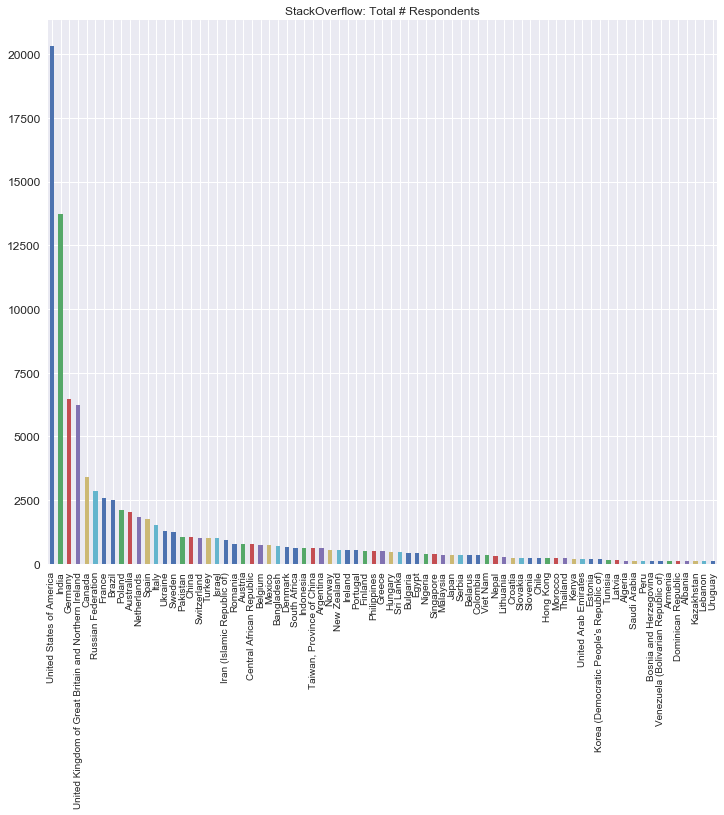

In [44]:
country_total = country_min['Country_Name'].value_counts().plot(kind='bar',figsize=(12,10), title="StackOverflow: Total # Respondents")


fig = country_total.get_figure()

name = "SO_countries_total-min100_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)

### 1.3. Country Ranking by Percent Female

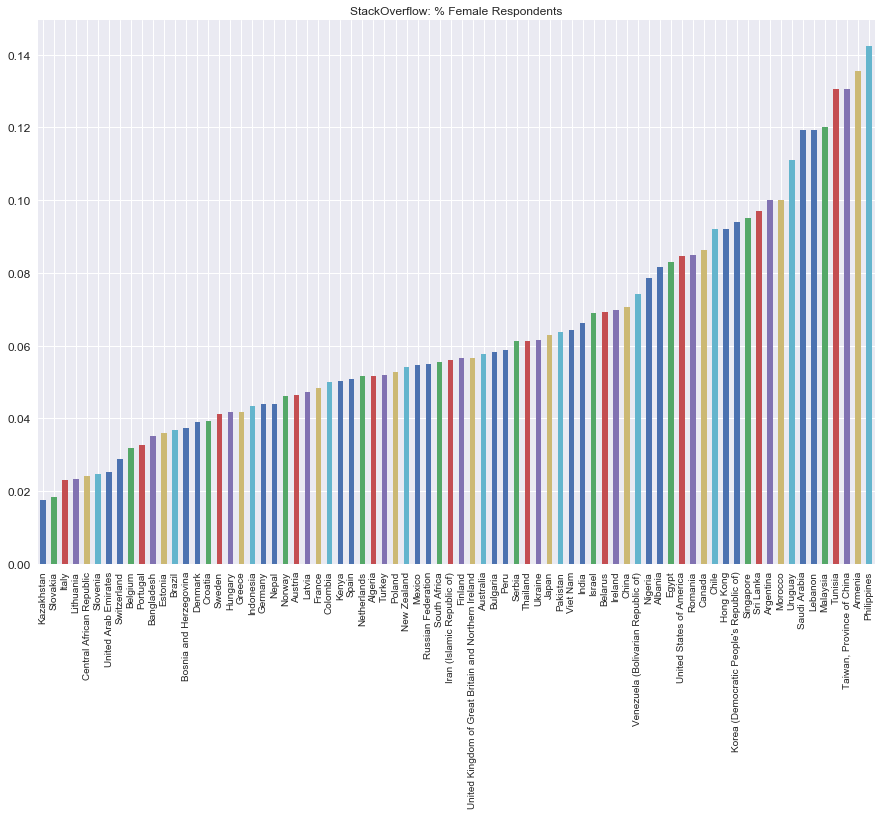

In [45]:
plt.xticks(rotation=90)
female_share_countries = female_share.sort_values().plot(kind='bar',figsize=(15,10), title="StackOverflow: % Female Respondents")


fig = female_share_countries.get_figure()

name = "SO_countries_female-share_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)

### 1.4. Regional Total Respondents

Europe      38060
Americas    29180
Asia        25489
Africa       3535
Oceania      2591
Name: region, dtype: int64



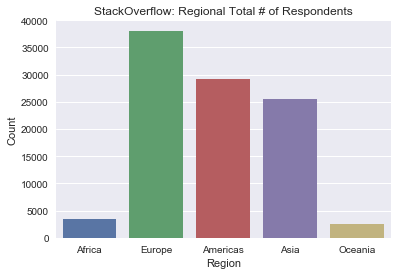

In [46]:
# Regional Count

#print(values['Country_Name'].value_counts())
print(values['region'].value_counts())

sns.set(font_scale=1)
count = sns.countplot(x='region', data=values)
count.set_xlabel('Region')
count.set_ylabel('Count')
count.set_title("StackOverflow: Regional Total # of Respondents")

fig = count.get_figure()

name = "SO_regional_total_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)
print("")

In [ ]:
#### TODO: Region-level Female Percent



# print(female_share['region'].value_counts())

# sns.set(font_scale=1)
# count = sns.countplot(x='region', data=female_share)
# count.set_xlabel('Region')
# count.set_ylabel('Count')
# print("")

### 1.5. Map of Total # of Respondents

In [51]:
### Map of Total # of Respondents


country = values['Country_Name'].value_counts()

# plotly 
data = [dict(
    type ='choropleth',
    locations = country.index,
    locationmode ='country names',
    z = country.values,
    text = 'female respondents',
    colorscale=[[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
    reversescale=True,
    marker=dict(line=dict(color='rgb(180,180,180)', width=0.5)),
    colorbar = dict(title ='Response count')
    )]
layout = dict(title = 'StackOverflow: Total Respondents by Country',
             geo = dict( showframe= False,
                       showcoastlines=True,
                       projection = dict(type = 'Mercator')))
fig = dict(data=data, layout=layout)

name = "SO_female_total"
save_location = save_maps + "\\" + name

offline.plot(fig, filename= save_location, image_filename=name,image='png')
print("Open this map: SO_female_total.png")


Open this map: SO_female_total.png


C:\Users\michael.madaio\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `analysis-output\maps\SO_female_total` didn't end with .html. Adding .html to the end of your file.



#### 1.6. Map of Percent Female Respondents by Country (above 100 respondents)

In [52]:
### Map of Percent Female Respondents by Country (above 100 respondents)

# plotly 
data = [dict(
    type ='choropleth',
    locations = female_share.index,
    locationmode ='country names',
    z = female_share.values,
    text = '% female',
    colorscale=[[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
    reversescale=True,
    marker=dict(line=dict(color='rgb(180,180,180)', width=0.5)),
    colorbar = dict(title ='Response count')
    )]
layout = dict(title = 'StackOverflow: Percent Female Respondents by Country',
             geo = dict( showframe= False,
                       showcoastlines=True,
                       projection = dict(type = 'Mercator')))
fig = dict(data=data, layout=layout)

name = "SO_female_percent"
save_location = save_maps + "\\" + name

offline.plot(fig, filename= save_location, image_filename=name,image='png')
print("Open this map: SO_female_percent.png")


Open this map: SO_female_percent.png


C:\Users\michael.madaio\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `analysis-output\maps\SO_female_percent` didn't end with .html. Adding .html to the end of your file.



## 2. Age and Years of Coding

In [53]:
# Function for drawing heatmaps

def draw_heatmap(column1, column2, title=None, annot=True, ax=None, size=(10, 10), data=values):
    cross = pd.crosstab(data[column1], data[column2], normalize='index')
    
    if ax is None:
        f, ax = plt.subplots(figsize=size)
        
    sns.heatmap(cross, cmap='Reds', fmt='g', annot=annot, ax=ax)
    
    if title is not None:
        ax.set_title(title)

### 2.1. Age and Years of Coding, by Gender

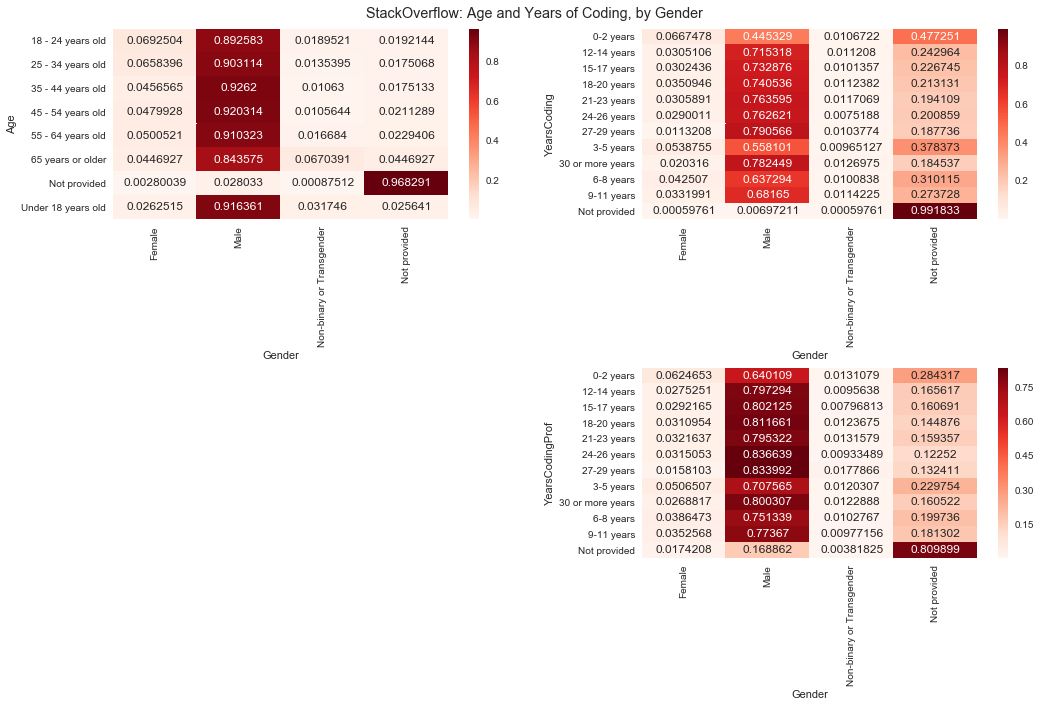

In [54]:
# Age and Age Started Coding

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

sns.set()
draw_heatmap('Age', 'Gender', ax=ax[0][0], annot=True, data=values)
ax[0][0].set_xlabel("Gender")
ax[0][0].set_ylabel("Age")

draw_heatmap('YearsCoding', 'Gender', ax=ax[0][1], annot=True, data=values)
ax[0][1].set_xlabel("Gender")
ax[0][1].set_ylabel("YearsCoding")

draw_heatmap('YearsCodingProf', 'Gender', ax=ax[1][1], annot=True, data=values)
ax[1][1].set_xlabel("Gender")
ax[1][1].set_ylabel("YearsCodingProf")

fig.suptitle("StackOverflow: Age and Years of Coding, by Gender")

fig.delaxes(ax[1][0])
fig.tight_layout() 
plt.subplots_adjust(top=0.95)


name = "SO_age_years-coding_gender.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


In [55]:
## Create male/female dataframes, for heatmapping

women = values[values["Gender"]=="Female"]
men = values[values["Gender"]=="Male"]

### 2.2. Combined Age and Years of Coding, by Gender

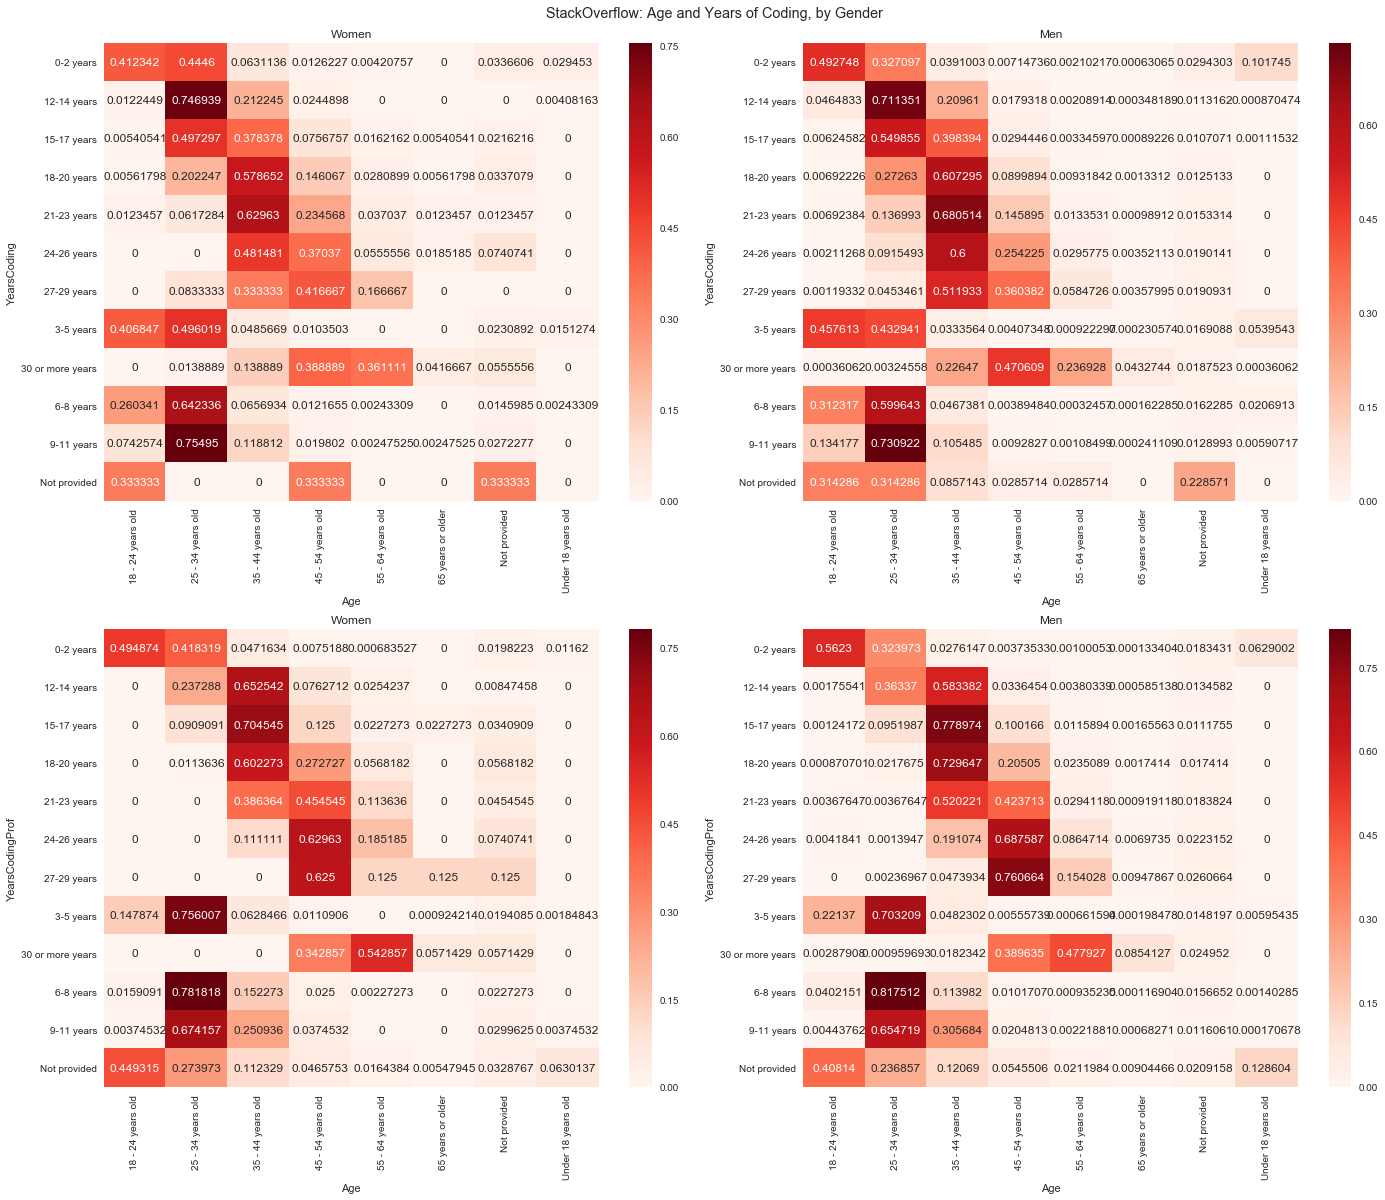

In [56]:
# Age and Age Started Coding, by Gender

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,17))
fig.suptitle("StackOverflow: Age and Years of Coding, by Gender")

sns.set()

draw_heatmap('YearsCoding', 'Age', ax=ax[0][0], annot=True, data=women)
ax[0][0].set_xlabel("Age")
ax[0][0].set_ylabel("YearsCoding")
ax[0][0].set_title('Women')

draw_heatmap('YearsCoding', 'Age', ax=ax[0][1], annot=True, data=men)
ax[0][1].set_xlabel("Age")
ax[0][1].set_ylabel("YearsCoding")
ax[0][1].set_title('Men')


draw_heatmap('YearsCodingProf', 'Age', ax=ax[1][0], annot=True, data=women)
ax[1][0].set_xlabel("Age")
ax[1][0].set_ylabel("YearsCodingProf")
ax[1][0].set_title('Women')

draw_heatmap('YearsCodingProf', 'Age', ax=ax[1][1], annot=True, data=men)
ax[1][1].set_xlabel("Age")
ax[1][1].set_ylabel("YearsCodingProf")
ax[1][1].set_title('Men')


fig.tight_layout() 
plt.subplots_adjust(top=0.95)

name = "SO_age_years-coding_gender_combined.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


## 3. Education

In [57]:
# Create new Dataframes for each region 

asia = values[values["region"] == "Asia"]
americas  = values[values["region"] == "Americas"]
europe  = values[values["region"] == "Europe"]
africa  = values[values["region"] == "Africa"]
oceania  = values[values["region"] == "Oceania"]


In [58]:
# Create new Dataframes for each Country case study 

indonesia = values[values["Country_Name"] == "Indonesia"]
argentina  = values[values["Country_Name"] == "Argentina"]
south_africa  = values[values["Country_Name"] == "South Africa"]
pakistan  = values[values["Country_Name"] == "Pakistan"]
rwanda  = values[values["Country_Name"] == "Rwanda"]

### 3.1. Education, by Gender

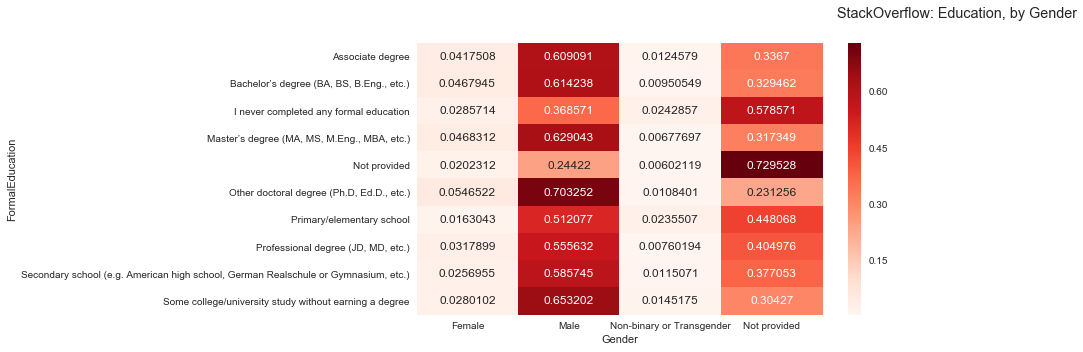

In [59]:
# Formal Education by Gender

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[0], annot=True, data=values)
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("FormalEducation")

fig.delaxes(ax[1])
fig.suptitle("StackOverflow: Education, by Gender")


name = "SO_education_gender.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 3.2. Education, by Gender and Region

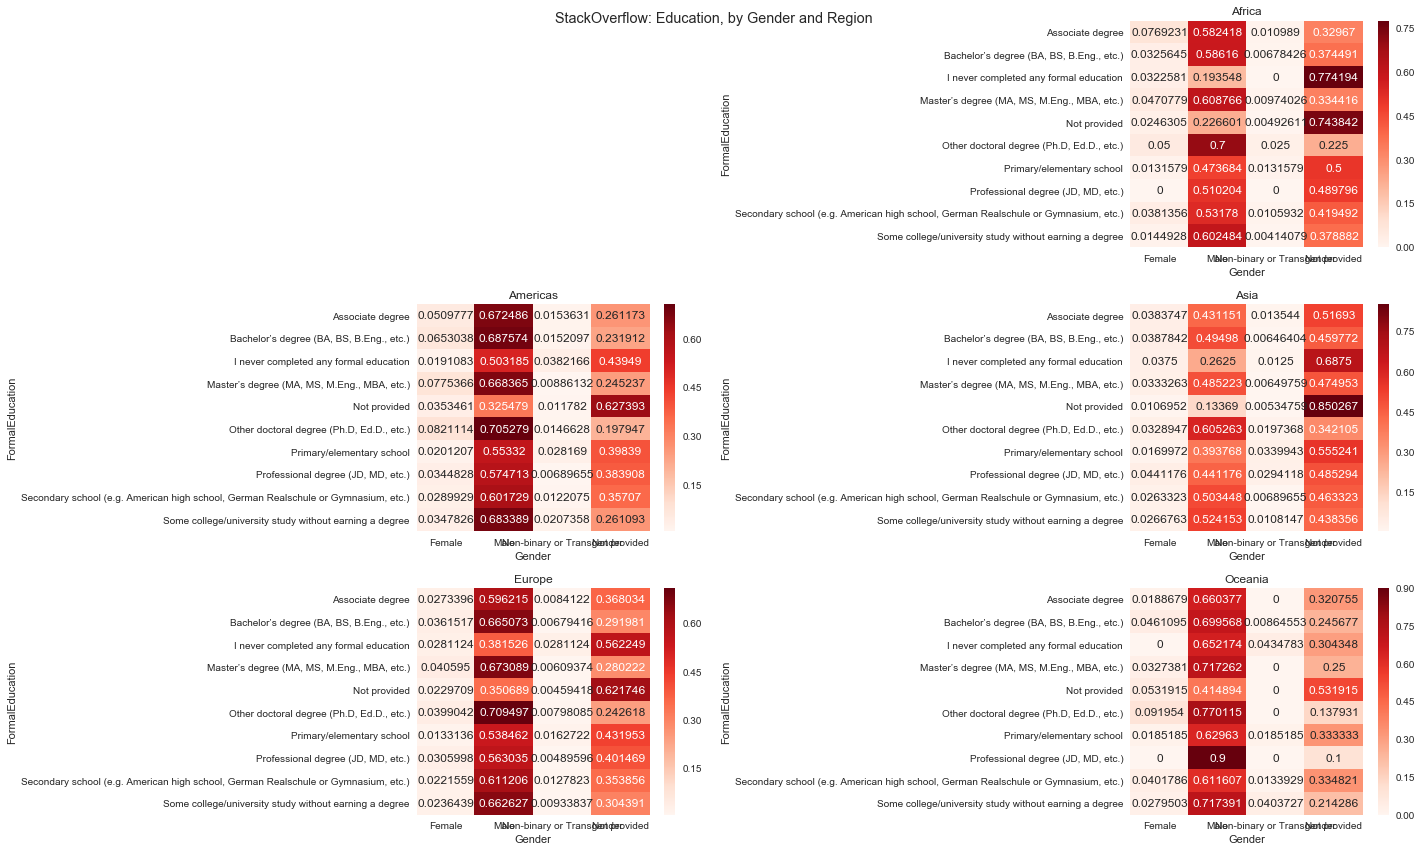

In [60]:
# Formal Education, by Gender and Region

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,12))


sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[0][1], annot=True, data=africa)
ax[0][1].set_title('Africa')

sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[1][0], annot=True, data=americas)
ax[1][0].set_title('Americas')

sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[1][1], annot=True, data=asia)
ax[1][1].set_title('Asia')

sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[2][0], annot=True, data=europe)
ax[2][0].set_title('Europe')

sns.set()
draw_heatmap('FormalEducation', 'Gender', ax=ax[2][1], annot=True, data=oceania)
ax[2][1].set_title('Oceania')

fig.delaxes(ax[0][0])
fig.suptitle("StackOverflow: Education, by Gender and Region")

fig.tight_layout() 

name = "SO_education_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


#### Total respondents for 4 Countries

In [61]:
print("Argentina:", len(argentina), "\nIndonesia:", len(indonesia), "\nSouth Africa:", len(south_africa), "\nPakistan", len(pakistan), "\nRwanda", len(rwanda))

Argentina: 611 
Indonesia: 630 
South Africa: 637 
Pakistan 1050 
Rwanda 18


### 3.3. Education, by Gender, for 4 Countries

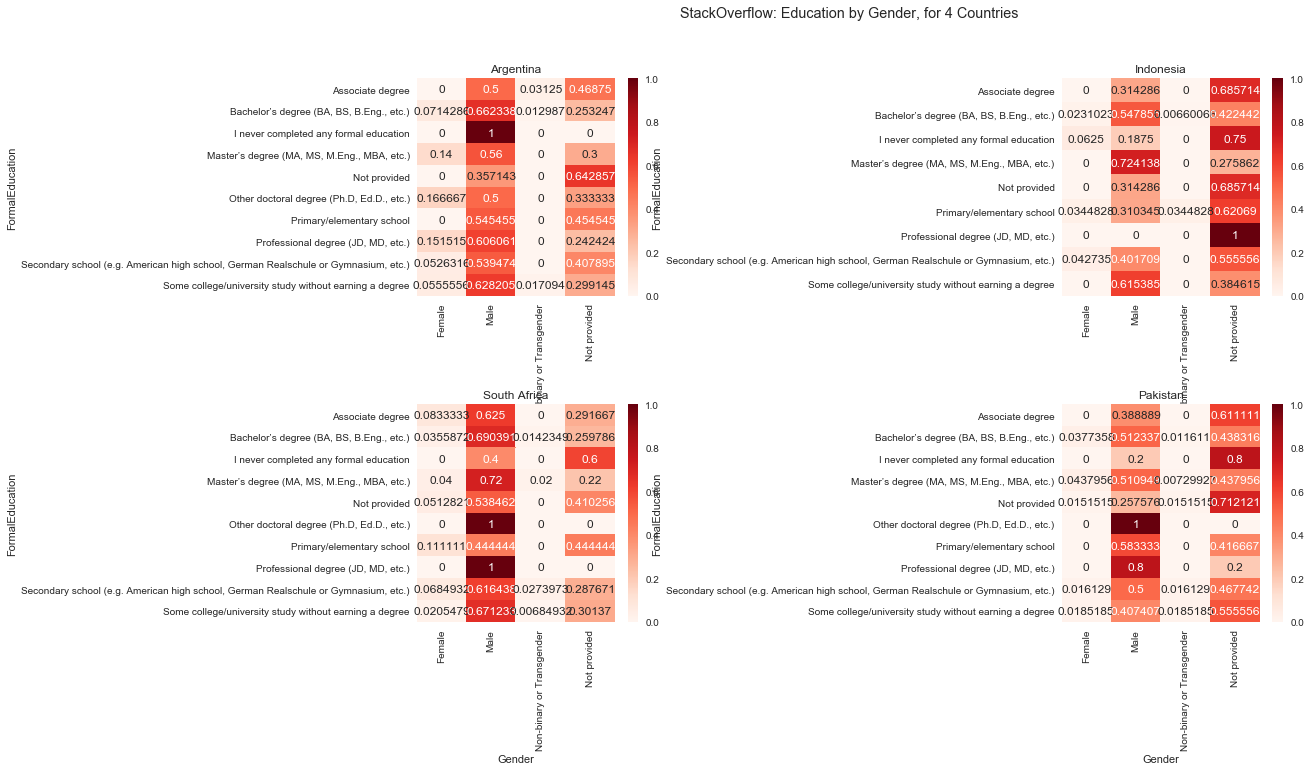

In [62]:
# Formal Education, for 4 countries

f,ax = plt.subplots(2,2, figsize=(16,10))

question = 'FormalEducation'

sns.set()
draw_heatmap(question, 'Gender', ax=ax[0][0], annot=True, data=argentina)
ax[0][0].set_title('Argentina')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[0][1], annot=True, data=indonesia)
ax[0][1].set_title('Indonesia')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[1][0], annot=True, data=south_africa)
ax[1][0].set_title('South Africa')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[1][1], annot=True, data=pakistan)
ax[1][1].set_title('Pakistan')
plt.suptitle("StackOverflow: Education by Gender, for 4 Countries")

plt.subplots_adjust(hspace=0.5, wspace=1.6)

name = "SO_education_gender_4countries.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

## 4. Employment

### 4.1. Employment, by Gender

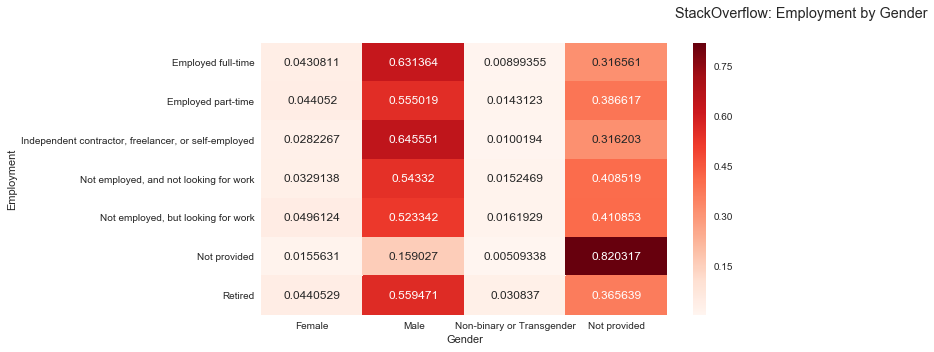

In [63]:
# Employment by Gender

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[0], annot=True, data=values)
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("Employment")
fig.suptitle("StackOverflow: Employment by Gender")
fig.delaxes(ax[1])

name = "SO_employment_gender.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 4.2. Employment, by Gender and Region

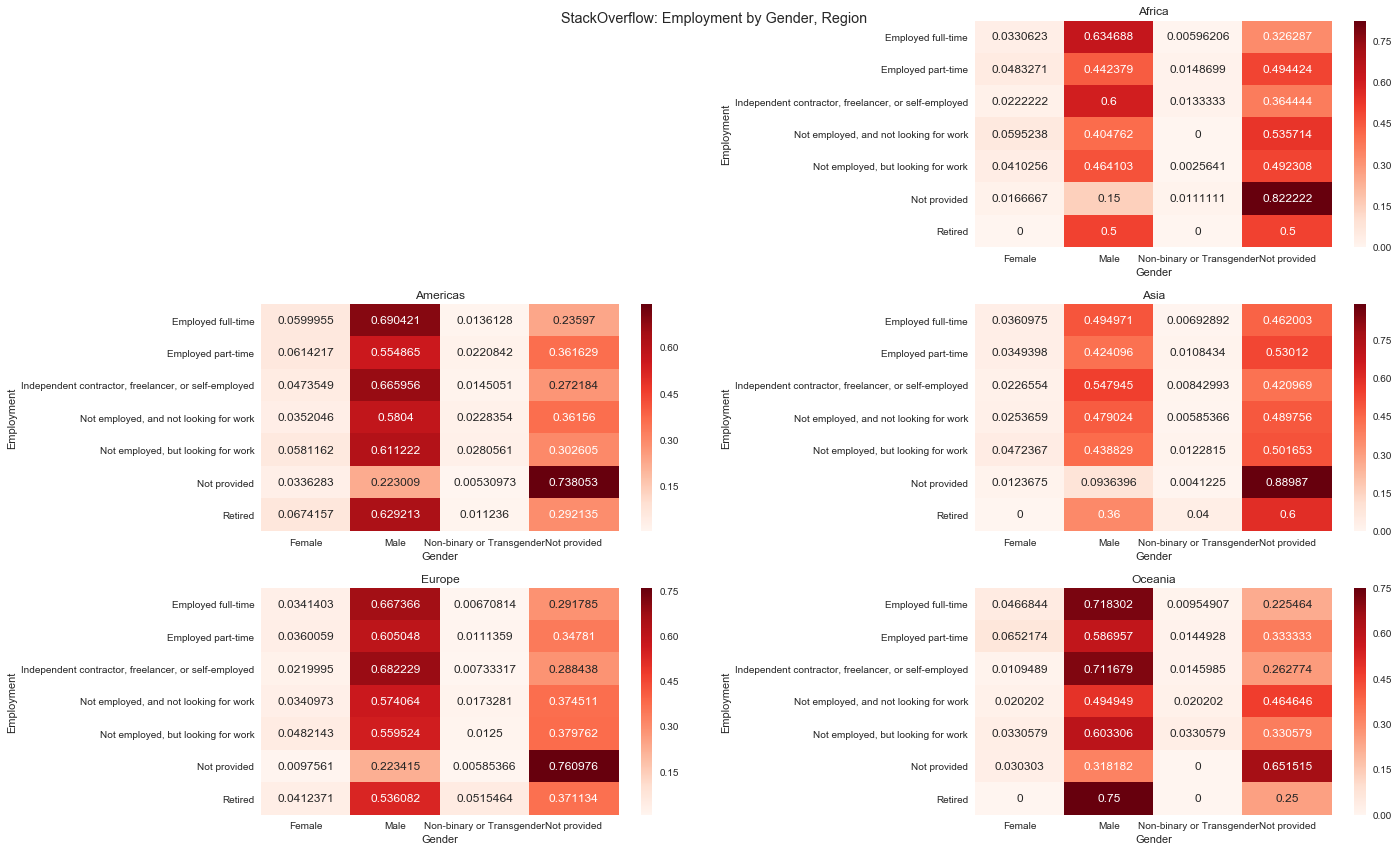

In [64]:
# Employment, by Gender and Region

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,12))


sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[0][1], annot=True, data=africa)
ax[0][1].set_title('Africa')

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[1][0], annot=True, data=americas)
ax[1][0].set_title('Americas')

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[1][1], annot=True, data=asia)
ax[1][1].set_title('Asia')

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[2][0], annot=True, data=europe)
ax[2][0].set_title('Europe')

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[2][1], annot=True, data=oceania)
ax[2][1].set_title('Oceania')

fig.delaxes(ax[0][0])
fig.tight_layout() 
plt.suptitle("StackOverflow: Employment by Gender, Region")

name = "SO_employment_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

### 4.3. Employment, by Gender, for 4 Countries

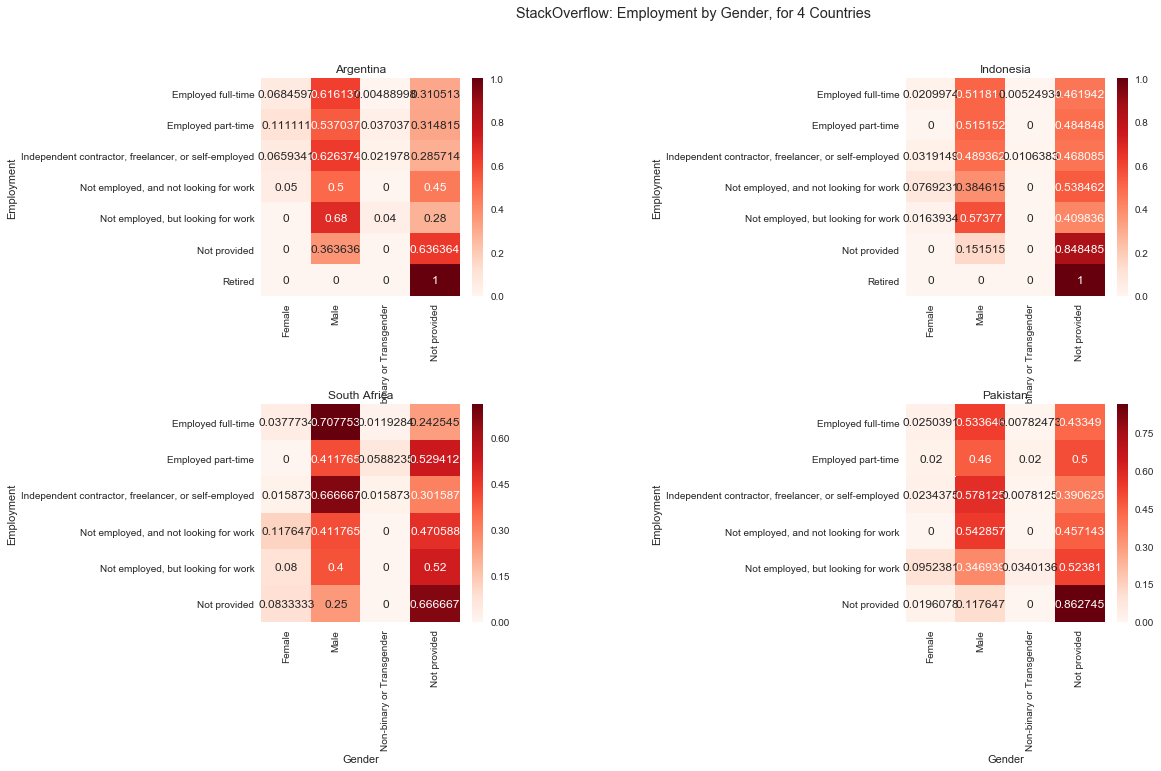

In [65]:
#### Employment, for 4 countries

f,ax = plt.subplots(2,2, figsize=(16,10))

question = 'Employment'

sns.set()
draw_heatmap(question, 'Gender', ax=ax[0][0], annot=True, data=argentina)
ax[0][0].set_title('Argentina')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[0][1], annot=True, data=indonesia)
ax[0][1].set_title('Indonesia')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[1][0], annot=True, data=south_africa)
ax[1][0].set_title('South Africa')

sns.set()
draw_heatmap(question, 'Gender', ax=ax[1][1], annot=True, data=pakistan)
ax[1][1].set_title('Pakistan')

plt.suptitle("StackOverflow: Employment by Gender, for 4 Countries")
plt.subplots_adjust(hspace=0.5, wspace=1.6)

name = "SO_employment_gender_4countries.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

### 4.4. Employment, by Company Size

In [66]:
print(values["CompanySize"].value_counts())

Not provided                27324
20 to 99 employees          16996
100 to 499 employees        14011
10,000 or more employees     9757
10 to 19 employees           8007
1,000 to 4,999 employees     7634
Fewer than 10 employees      7479
500 to 999 employees         4630
5,000 to 9,999 employees     3017
Name: CompanySize, dtype: int64


In [67]:
## Subset only those employed at a company

employed = values[(values["Employment"] == "Employed full-time") | (values["Employment"] == "Employed part-time")]
print(employed["Employment"].value_counts())

female_employed = employed[employed["Gender"] == "Female"]
male_employed = employed[employed["Gender"] == "Male"]

Employed full-time    70495
Employed part-time     5380
Name: Employment, dtype: int64


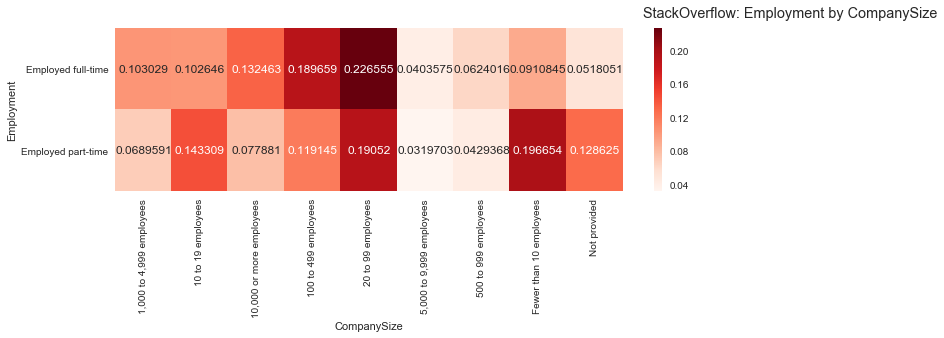

In [68]:
# Employment by Company Size

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,3))

sns.set()
draw_heatmap('Employment', 'CompanySize', ax=ax[0], annot=True, data=employed)
ax[0].set_xlabel("CompanySize")
ax[0].set_ylabel("Employment")


fig.suptitle("StackOverflow: Employment by CompanySize")
fig.delaxes(ax[1])

name = "SO_employment_company_size.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 4.5. Employment, by Company Size and Gender

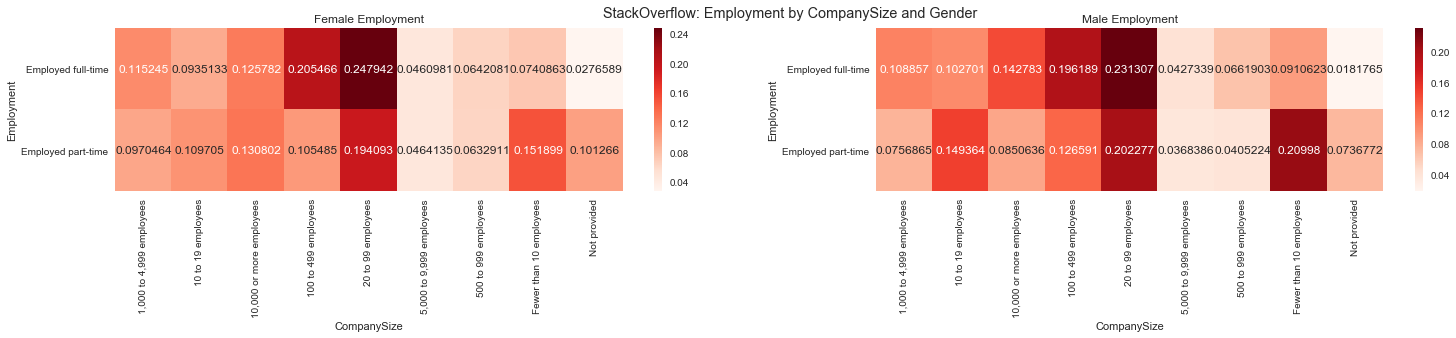

In [69]:
# Employment by Company Size, Gender

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,3))

sns.set()
draw_heatmap('Employment', 'CompanySize', ax=ax[0], annot=True, data=female_employed)
ax[0].set_xlabel("CompanySize")
ax[0].set_ylabel("Employment")
ax[0].set_title('Female Employment')


draw_heatmap('Employment', 'CompanySize', ax=ax[1], annot=True, data=male_employed)
ax[1].set_xlabel("CompanySize")
ax[1].set_ylabel("Employment")
ax[1].set_title('Male Employment')


fig.suptitle("StackOverflow: Employment by CompanySize and Gender")

name = "SO_employment_company_size.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


## 5. Company Size

### 5.1. Company Size, by Gender

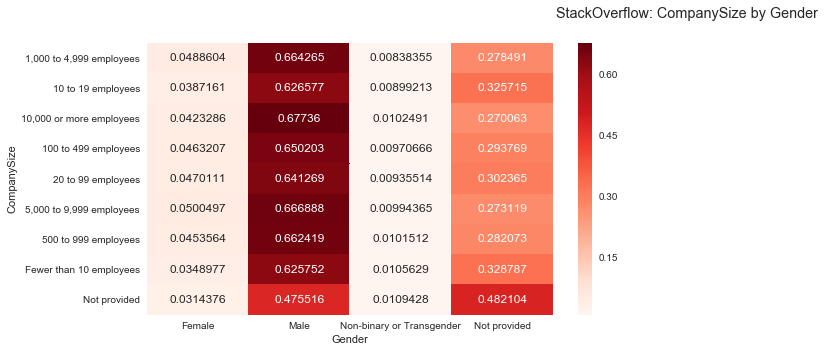

In [70]:
# Company Size by Gender

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[0], annot=True, data=values)
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("CompanySize")
fig.suptitle("StackOverflow: CompanySize by Gender")
fig.delaxes(ax[1])

name = "SO_company_size_gender.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 5.2. Company Size, by Region

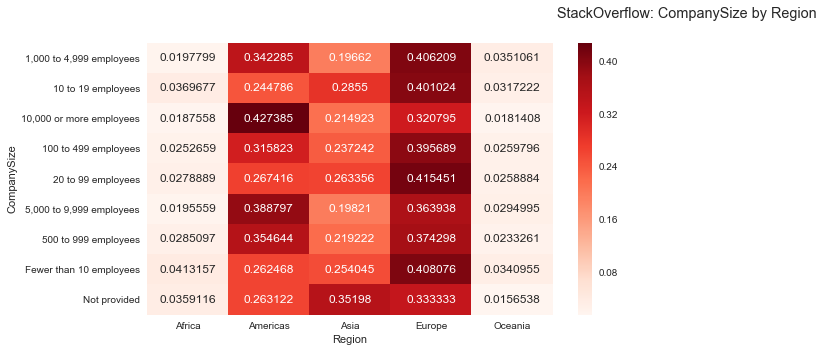

In [71]:
# Company Size by Region

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.set()
draw_heatmap('CompanySize', 'region', ax=ax[0], annot=True, data=employed)
ax[0].set_xlabel("Region")
ax[0].set_ylabel("CompanySize")
fig.suptitle("StackOverflow: CompanySize by Region")
fig.delaxes(ax[1])

name = "SO_company_size_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 5.3. Company Size, by Gender and Region

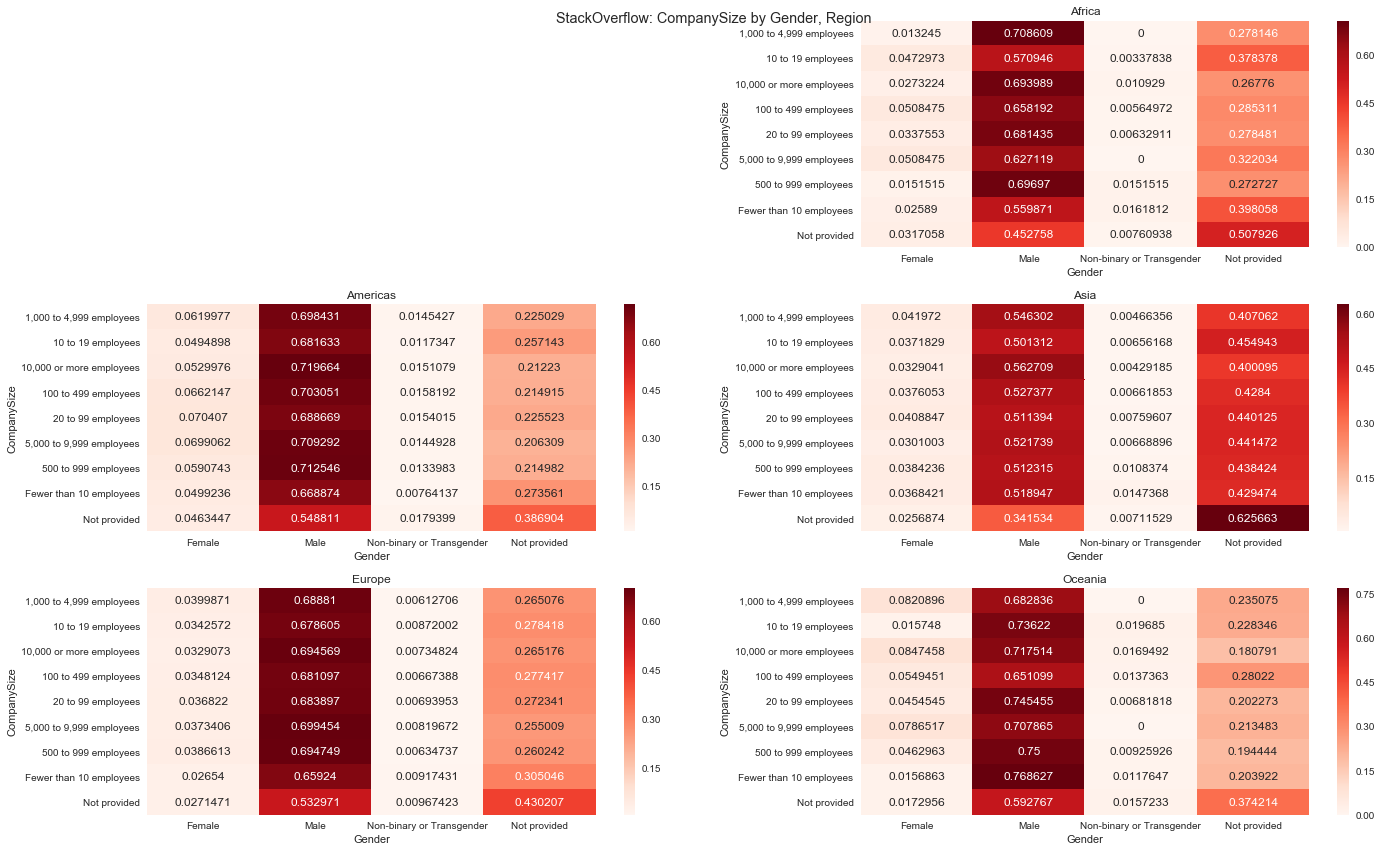

In [72]:
# Company Size, by Gender and Region

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,12))


sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[0][1], annot=True, data=africa)
ax[0][1].set_title('Africa')

sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[1][0], annot=True, data=americas)
ax[1][0].set_title('Americas')

sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[1][1], annot=True, data=asia)
ax[1][1].set_title('Asia')

sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[2][0], annot=True, data=europe)
ax[2][0].set_title('Europe')

sns.set()
draw_heatmap('CompanySize', 'Gender', ax=ax[2][1], annot=True, data=oceania)
ax[2][1].set_title('Oceania')

fig.delaxes(ax[0][0])
fig.tight_layout() 
plt.suptitle("StackOverflow: CompanySize by Gender, Region")

name = "SO_company_size_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

### 5.4. Company Size, by Gender and Region (Alternative view)

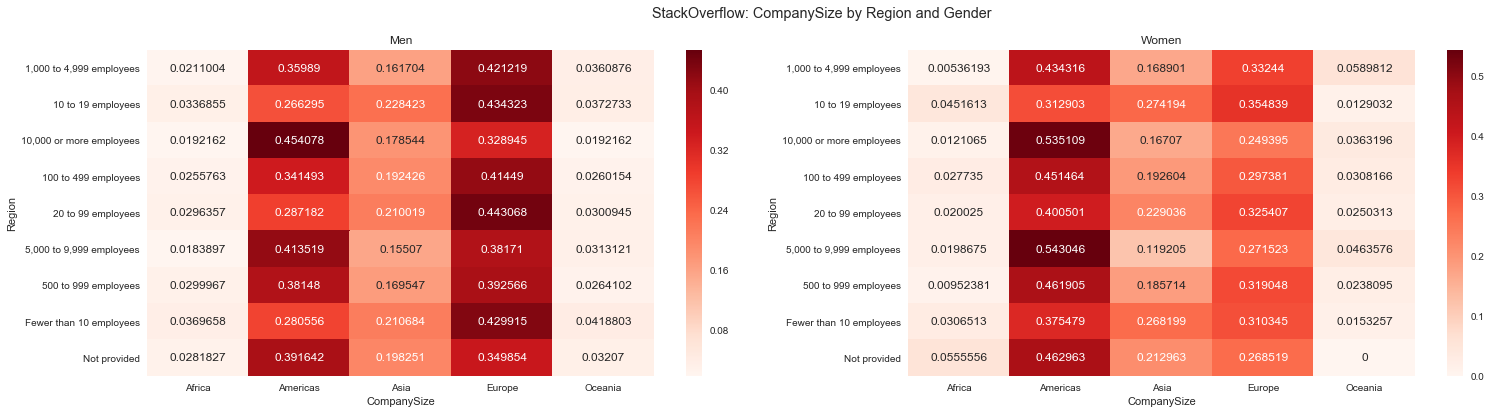

In [73]:
# Company Size, by Gender, Region

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

sns.set()
draw_heatmap('CompanySize', 'region', ax=ax[0], annot=True, data=male_employed)
ax[0].set_xlabel("CompanySize")
ax[0].set_ylabel("Region")
ax[0].set_title('Men')


draw_heatmap('CompanySize', 'region', ax=ax[1], annot=True, data=female_employed)
ax[1].set_xlabel("CompanySize")
ax[1].set_ylabel("Region")
ax[1].set_title('Women')


fig.suptitle("StackOverflow: CompanySize by Region and Gender")

name = "SO_company_size_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


## 6. Computer Science (and related) Degrees

In [74]:
print(values["UndergradMajor"].value_counts())

Computer science, computer engineering, or software engineering          50336
Not provided                                                             19819
Another engineering discipline (ex. civil, electrical, mechanical)        6945
Information systems, information technology, or system administration     6507
A natural science (ex. biology, chemistry, physics)                       3050
Mathematics or statistics                                                 2818
Web development or web design                                             2418
A business discipline (ex. accounting, finance, marketing)                1921
A humanities discipline (ex. literature, history, philosophy)             1590
A social science (ex. anthropology, psychology, political science)        1377
Fine arts or performing arts (ex. graphic design, music, studio art)      1135
I never declared a major                                                   693
A health science (ex. nursing, pharmacy, radiology) 

In [75]:
## Create male/female dataframes for CS and non-CS graduates, for heatmapping

CS_overall = values[(values["UndergradMajor"]=="Computer science, computer engineering, or software engineering") | (values["UndergradMajor"]== "Information systems, information technology, or system administration") | (values["UndergradMajor"] == "Web development or web design")]

non_CS_overall = values[(values["UndergradMajor"]!="Computer science, computer engineering, or software engineering") & (values["UndergradMajor"]!= "Information systems, information technology, or system administration") & (values["UndergradMajor"] != "Web development or web design")]
 

CS_women = women[(women["UndergradMajor"]=="Computer science, computer engineering, or software engineering") | (women["UndergradMajor"]== "Information systems, information technology, or system administration") | (women["UndergradMajor"] == "Web development or web design")]

non_CS_women = women[(women["UndergradMajor"]!="Computer science, computer engineering, or software engineering") & (women["UndergradMajor"]!= "Information systems, information technology, or system administration") & (women["UndergradMajor"] != "Web development or web design")]

CS_men = men[(men["UndergradMajor"]=="Computer science, computer engineering, or software engineering") | (men["UndergradMajor"]== "Information systems, information technology, or system administration") | (men["UndergradMajor"] == "Web development or web design")]

non_CS_men = men[(men["UndergradMajor"]!="Computer science, computer engineering, or software engineering") & (men["UndergradMajor"]!= "Information systems, information technology, or system administration") & (men["UndergradMajor"] != "Web development or web design")]


### 6.1. CS Degrees, by Gender

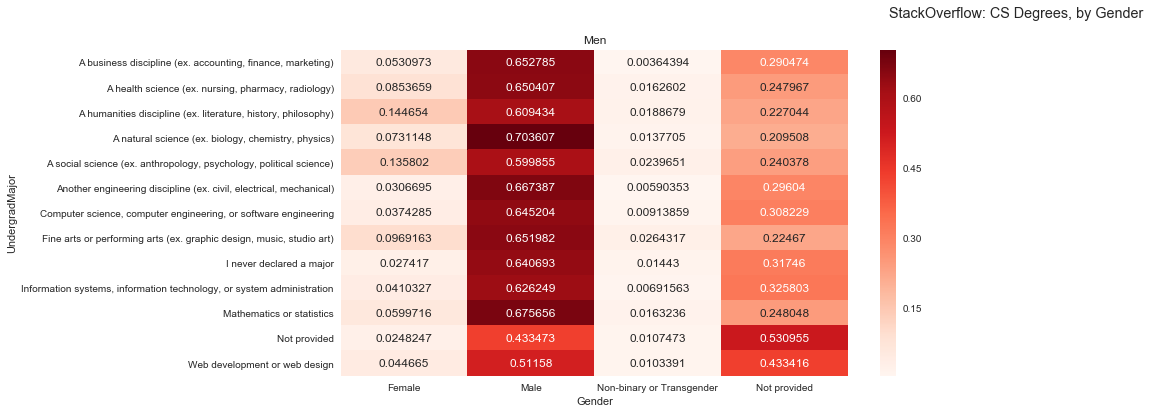

In [76]:
# CS Degrees, by Gender
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[0], annot=True, data=values)
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("UndergradMajor")
ax[0].set_title('Men')


fig.suptitle("StackOverflow: CS Degrees, by Gender")

fig.delaxes(ax[1])

name = "SO_degree_gender.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 6.2. CS Degrees, by Gender and Region

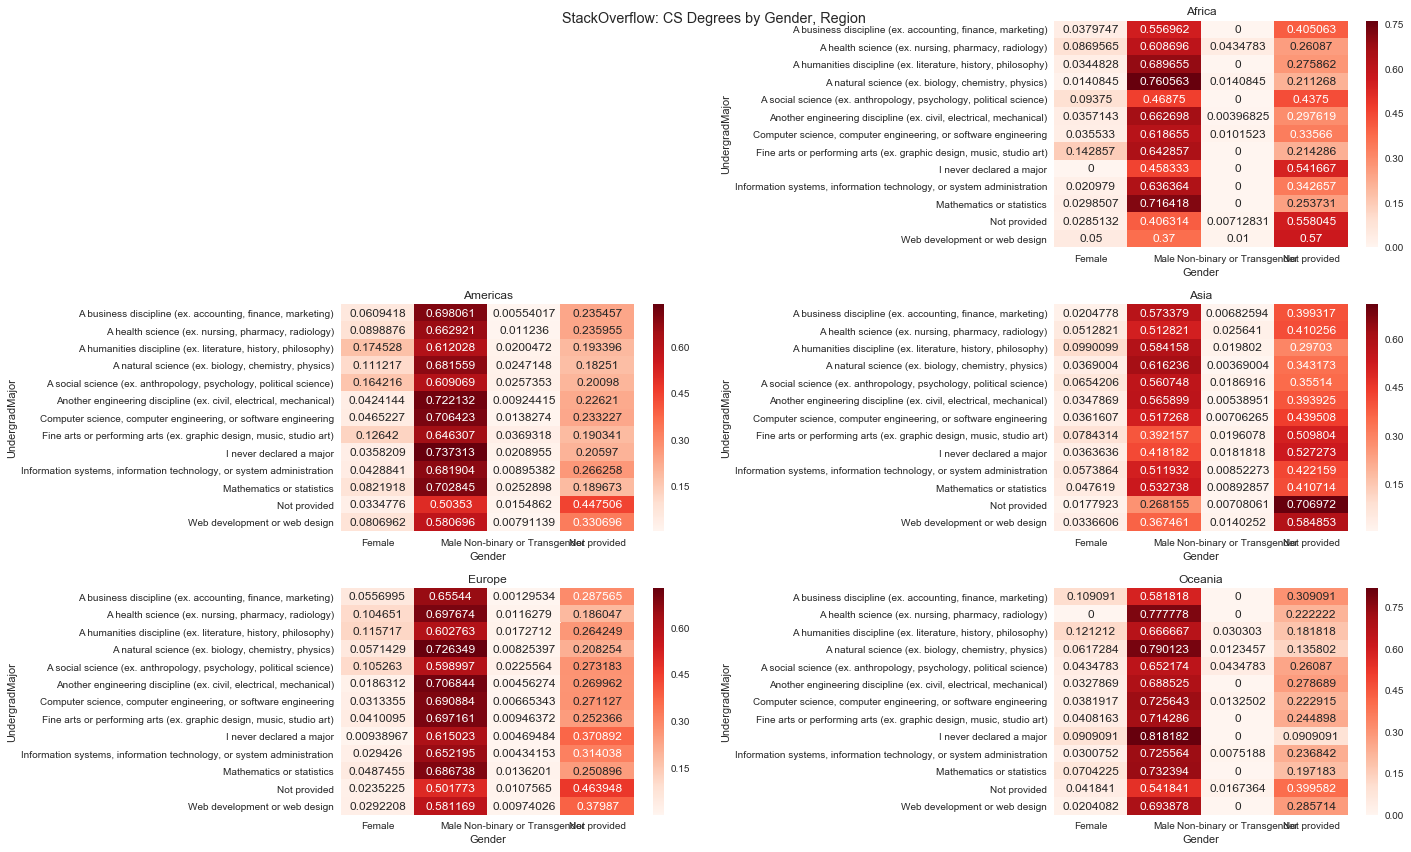

In [77]:
# CS Degrees, by Gender and Region

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,12))


sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[0][1], annot=True, data=africa)
ax[0][1].set_title('Africa')

sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[1][0], annot=True, data=americas)
ax[1][0].set_title('Americas')

sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[1][1], annot=True, data=asia)
ax[1][1].set_title('Asia')

sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[2][0], annot=True, data=europe)
ax[2][0].set_title('Europe')

sns.set()
draw_heatmap('UndergradMajor', 'Gender', ax=ax[2][1], annot=True, data=oceania)
ax[2][1].set_title('Oceania')

fig.delaxes(ax[0][0])
fig.tight_layout() 
plt.suptitle("StackOverflow: CS Degrees by Gender, Region")

name = "SO_degree_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

### 6.3. CS Degrees, by Employment and Gender

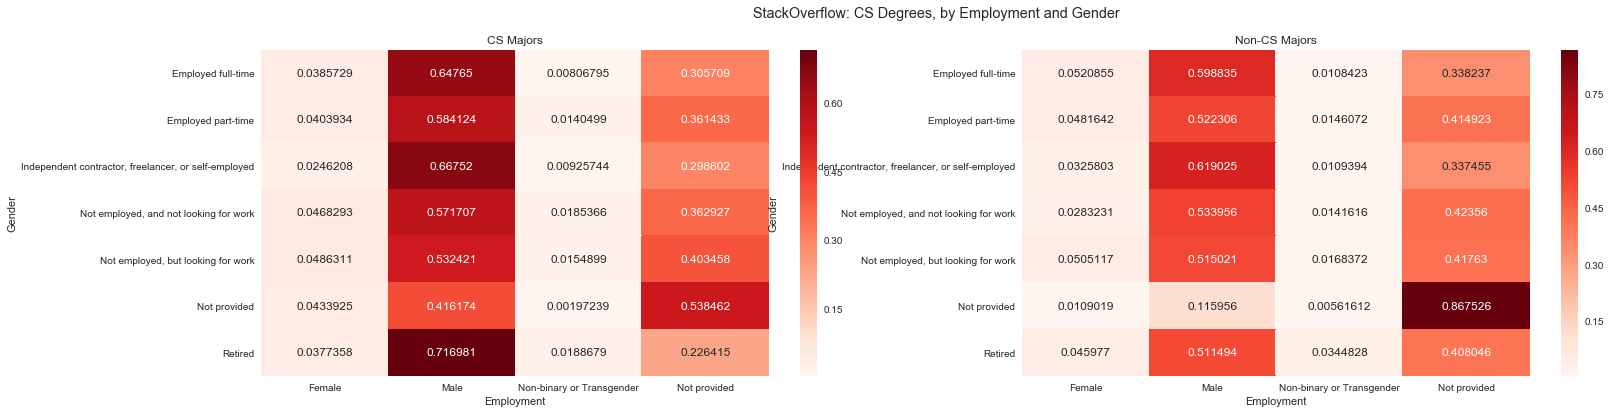

In [78]:
# CS Degrees, by Employment and Gender

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

sns.set()
draw_heatmap('Employment', 'Gender', ax=ax[0], annot=True, data=CS_overall)
ax[0].set_xlabel("Employment")
ax[0].set_ylabel("Gender")
ax[0].set_title('CS Majors')


draw_heatmap('Employment', 'Gender', ax=ax[1], annot=True, data=non_CS_overall)
ax[1].set_xlabel("Employment")
ax[1].set_ylabel("Gender")
ax[1].set_title('Non-CS Majors')


fig.suptitle("StackOverflow: CS Degrees, by Employment and Gender")

name = "SO_degree_gender_employment.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


### 6.4. Women with CS Degrees, by Employment and Region

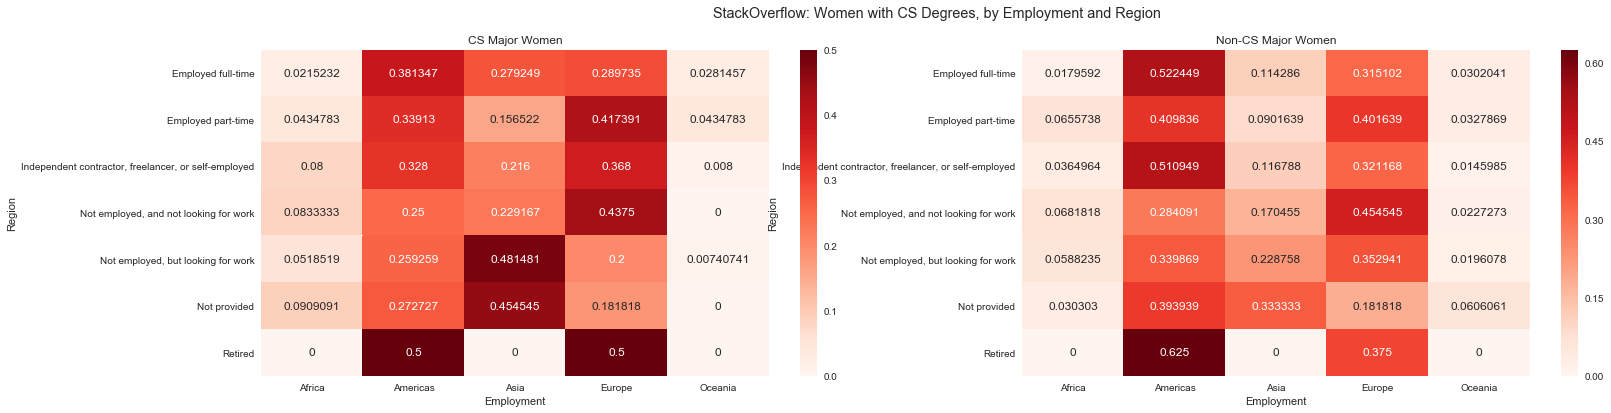

In [79]:
# Women with CS Degrees, by Employment and Region


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,6))

sns.set()
draw_heatmap('Employment', 'region', ax=ax[0], annot=True, data=CS_women)
ax[0].set_xlabel("Employment")
ax[0].set_ylabel("Region")
ax[0].set_title('CS Major Women')


draw_heatmap('Employment', 'region', ax=ax[1], annot=True, data=non_CS_women)
ax[1].set_xlabel("Employment")
ax[1].set_ylabel("Region")
ax[1].set_title('Non-CS Major Women')


fig.suptitle("StackOverflow: Women with CS Degrees, by Employment and Region")

name = "SO_degree_employment_region+_female.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)


## 7. Job Level

### 7.1. Developers, by Gender

In [80]:
developers = values[values['DevType'].str.contains("developer")]
print(developers["Gender"].value_counts())

Male                         52968
Not provided                 25210
Female                        3340
Non-binary or Transgender      843
Name: Gender, dtype: int64


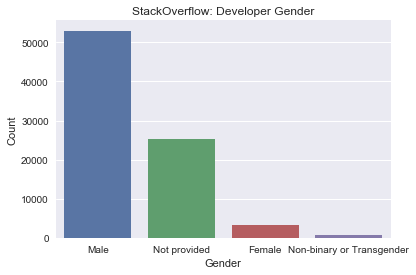

In [81]:
## Barchart of Gender of Developers

sns.set(font_scale=1)
count = sns.countplot(x='Gender', data=developers)
count.set_xlabel('Gender')
count.set_ylabel('Count')
count.set_title("StackOverflow: Developer Gender")

fig = count.get_figure()

name = "SO_devtype_dev_gender_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)
print("")



### 7.2. Managers, by Gender

In [82]:
managers = values[values['DevType'].str.contains("manager")]
print(managers["Gender"].value_counts())

Male                         5741
Not provided                 2237
Female                        247
Non-binary or Transgender     115
Name: Gender, dtype: int64


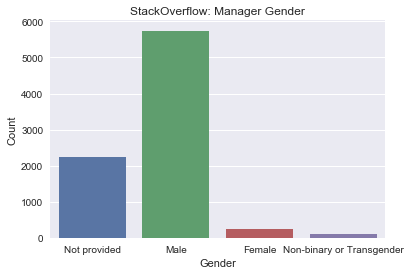

In [83]:
## Barchart of Gender of Managers

sns.set(font_scale=1)
count = sns.countplot(x='Gender', data=managers)
count.set_xlabel('Gender')
count.set_ylabel('Count')
count.set_title("StackOverflow: Manager Gender")

fig = count.get_figure()

name = "SO_devtype_manager_gender_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)

print("")

### 7.3. Executives, by Gender

In [84]:
executives = values[values['DevType'].str.contains("executive")]
print(executives["Gender"].value_counts())


Male                         2327
Not provided                 1067
Non-binary or Transgender      53
Female                         44
Name: Gender, dtype: int64


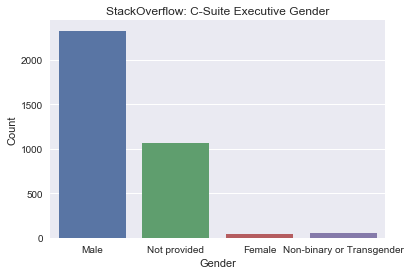

In [85]:
## Barchart of Gender of C-Suite Executives

sns.set(font_scale=1)
count = sns.countplot(x='Gender', data=executives)
count.set_xlabel('Gender')
count.set_ylabel('Count')
count.set_title("StackOverflow: C-Suite Executive Gender")

name = "SO_devtype_executive_gender_barplot.jpg"
save_location = save_images + "\\" + name
fig.savefig(save_location)


print("")

### 7.4. Job Types, by Gender and Region

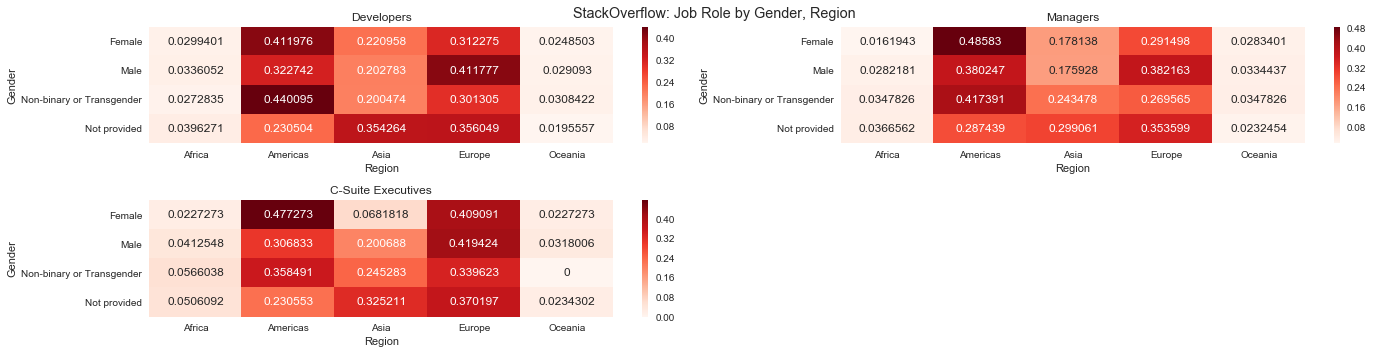

In [86]:
# Developers by Gender, Region

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,5))

sns.set()
draw_heatmap('Gender', 'region', ax=ax[0][0], annot=True, data=developers)
ax[0][0].set_xlabel("Region")
ax[0][0].set_ylabel("Gender")
ax[0][0].set_title("Developers")


draw_heatmap('Gender', 'region', ax=ax[0][1], annot=True, data=managers)
ax[0][1].set_xlabel("Region")
ax[0][1].set_ylabel("Gender")
ax[0][1].set_title("Managers")


draw_heatmap('Gender', 'region', ax=ax[1][0], annot=True, data=executives)
ax[1][0].set_xlabel("Region")
ax[1][0].set_ylabel("Gender")
ax[1][0].set_title("C-Suite Executives")

fig.delaxes(ax[1][1])

plt.suptitle("StackOverflow: Job Role by Gender, Region")
fig.tight_layout() 


name = "SO_devtype_gender_region.jpg"
save_location = save_images + "\\" + name
plt.savefig(save_location)

